In [3]:
import pandas
import itertools as it
lookup_table = pandas.read_csv("./legacy/valid_values.csv", sep = ";")

print(lookup_table[0:3])

   NumChickens FieldArea ItemSurfaceArea
0           21      5625           19,24
1           21   6944,44           19,24
2           21   8402,78           19,24


In [10]:
lookup_table.reset_index()
for i, data in lookup_table.iterrows():
    if i > 0:
        break
    print(i)
    print(data)
    

0
NumChickens           21
FieldArea           5625
ItemSurfaceArea    19,24
Name: 0, dtype: object


In [4]:
from typing import Tuple, List
import math
import numpy as np
def compute_canonical_parameters(n_chickens: int, field_area: float, chicken_size: float) -> Tuple[float, float, float, float]:
    FA = (((0.006) * math.sqrt(field_area))**2)*math.pi
    

def compute_nd_nnd_coords(trial_left: List[float], trial_right: List[float]) -> Tuple[float, float]:
    #formula specified by previous thesis writers
    #NND = (0.577+0.467∗Number)∗(FA/Number) +(0.487+0.473∗Number)∗ISA
    nnd_right = (0.577+0.467*trial_right[0])*(trial_right[1]/trial_right[0]) + (0.487+0.473*trial_right[0])*trial_right[2]
    nnd_left = (0.577+0.467*trial_left[0])*(trial_left[1]/trial_left[0]) + (0.487+0.473*trial_left[0])*trial_left[2]

    return np.log10(trial_right[0]/trial_left[0]), np.log10(nnd_right/nnd_left)

In [54]:
import random
data = {}
columns = ["Unnamed","NumLeft","FieldAreaLeft","ItemSurfaceAreaLeft","NumRight","FieldAreaRight","ItemSurfaceAreaRight","Ratio L/R","LogRatio","Log - Normalized","Difficulty Coefficient","Diff_coeff_filtering", "nd_LogRatio", "nnd_LogRatio"]

for c in columns:
    data[c] = []
i=0
for (ileft, dleft), (iright,dright) in it.combinations(lookup_table.sample(frac=1.0).iterrows(), 2):
    if dleft[0] == dright[0]:
        continue
    fAreaLeft = float(dleft[1].replace(",", "."))
    fAreaRight = float(dright[1].replace(",", "."))
    iAreaLeft = float(dleft[2].replace(",", "."))
    iAreaRight = float(dright[2].replace(",", "."))

    data["Unnamed"].append(i) 
    data["NumLeft"].append(dleft[0])
    data["FieldAreaLeft"].append(fAreaLeft)
    data["ItemSurfaceAreaLeft"].append(iAreaLeft)
    data["NumRight"].append(dright[0])
    data["FieldAreaRight"].append(fAreaRight)
    data["ItemSurfaceAreaRight"].append(iAreaRight)

    #nd and nnd coords, should be relevant for any kind of implemented ai 
    nd_logratio, nnd_logratio = compute_nd_nnd_coords([int(dleft[0]), fAreaLeft,iAreaLeft], [int(dright[0]), fAreaRight, iAreaRight])
    data["nd_LogRatio"].append(nd_logratio)
    data["nnd_LogRatio"].append(nnd_logratio)

    #old statistics, computed for backward compatibility
    data["Ratio L/R"].append(round((dleft[0]/dright[0]),2))
    data["LogRatio"].append(round(np.log10(round((dleft[0]/dright[0]),2)),2))
    data["Log - Normalized"].append(round(np.log10(round((dleft[0]/dright[0]),2)),2))
    data["Difficulty Coefficient"].append(round(random.uniform(0, 1), 2))
    data["Diff_coeff_filtering"].append(round(random.uniform(0,1), 2))

    

In [55]:
new_table = pandas.DataFrame(data = data, columns=columns)
print(new_table)

       Unnamed  NumLeft  FieldAreaLeft  ItemSurfaceAreaLeft  NumRight  \
0            0       37       20069.44                37.70         9   
1            0       37       20069.44                37.70        21   
2            0       37       20069.44                37.70        13   
3            0       37       20069.44                37.70         9   
4            0       37       20069.44                37.70         5   
...        ...      ...            ...                  ...       ...   
27834        0       37       22500.00                37.70       112   
27835        0       37       22500.00                37.70        45   
27836        0       37       25069.44                49.25       112   
27837        0       37       25069.44                49.25        45   
27838        0      112       40000.00                19.24        45   

       FieldAreaRight  ItemSurfaceAreaRight  Ratio L/R  LogRatio  \
0            22500.00                196.98       4.11 

In [52]:
# additional processing for backward compatibility
def diff_coef(i, x, y):
    try:
        if (x > 0 and y >= 0) or (x < 0 and y <= 0):
            k = math.atan(y/x)
        elif (x < 0 and y >= 0) or (x > 0 and y <= 0):
            k = math.pi - abs(math.atan(y/x))
        a = math.degrees(abs((math.pi/4)-k))
    except:
        return -1
    return a

#i think it's wrong normalizing and making decisions on normalized values,
#adding new trials can change the whole feature space, we are losing coherency with respect to Learning to Focus on Numbers
new_table["Log - Normalized"] = round(new_table["Log - Normalized"]/new_table["Log - Normalized"].max(),2).abs()
new_table["Difficulty Coefficient"] = round(1- new_table["Log - Normalized"],2)

max_nd = new_table['nd_LogRatio'].abs().max()
max_nnd = new_table['nnd_LogRatio'].abs().max()

filtering_diff = []
for i, row in new_table.iterrows():
    filtering_diff.append(diff_coef(i,row["nd_LogRatio"]/max_nd, row["nnd_LogRatio"]/max_nnd))

new_table["Diff_coeff_filtering"] = filtering_diff
new_table["Diff_coeff_filtering"] = new_table["Diff_coeff_filtering"]/new_table["Diff_coeff_filtering"].max()




In [53]:
import os
if os.path.exists("lookup_table.csv"):
    os.remove("lookup_table.csv")
new_table.to_csv("./lookup_table.csv")

# Some analysis

In [9]:
import pandas
lookup_table = pandas.read_csv("./lookup_table.csv")

print(lookup_table['nd_LogRatio'].min())
print(lookup_table['nd_LogRatio'].max())
print(lookup_table['nnd_LogRatio'].min())
print(lookup_table['nnd_LogRatio'].max())
#highest = lookup_table.iloc((lookup_table['nd_LogRatio']).abs().argsort()[:1])

-2.004321373782642
2.049218022670181
-0.8816194191065028
0.8542775057372487


In [10]:
okay = False
count = 0
count_two=0
for row in lookup_table.iterrows():
    row=row[1]
    if row["nd_LogRatio"] >0 and row["nnd_LogRatio"]<0:
        #print(row)
        okay = True
        #assert False == True
        count+=1
    if row["nd_LogRatio"] <0 and row["nnd_LogRatio"]>0:
        count_two +=1

print(okay)
print(count)
print(count_two)

True
4876
4158


In [11]:
max_nd = lookup_table['nd_LogRatio'].abs().max()
max_nnd = lookup_table['nnd_LogRatio'].abs().max()

lookup_table['nd_LogRatio'] = lookup_table['nd_LogRatio'].abs()/max_nd
lookup_table['nnd_LogRatio'] = lookup_table['nnd_LogRatio'].abs()/max_nnd

In [12]:
import matplotlib.pyplot as plt
import numpy as np
def myHistogram(data: np.ndarray,n_labels:int,labels:np.ndarray, bins: int=20):
    colors = ["red", "green", "blue","orange" , "gray", "orange"]

    for i in range(0,data.shape[0]):
        for j in range(0,n_labels):
            plt.hist(data[i, labels == j],bins=bins, density=True, color=colors[j],alpha=0.6, histtype='bar', rwidth=0.9)
        plt.show()

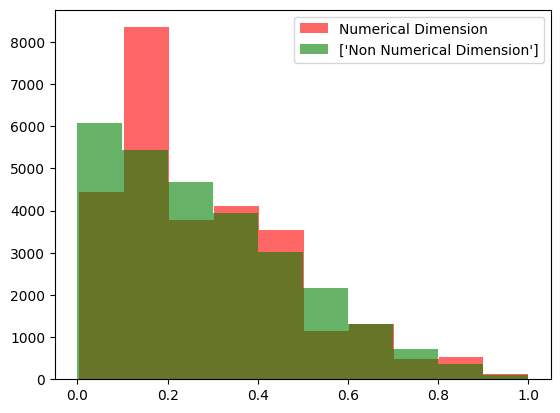

In [13]:
nd_logratio = lookup_table["nd_LogRatio"]
nnd_logratio = lookup_table["nnd_LogRatio"]

nd =plt.hist(nd_logratio, color="red", histtype='bar', alpha=0.6)
nnd =plt.hist(nnd_logratio, color = "green",  histtype='bar', alpha=0.6)

plt.legend(["Numerical Dimension", ["Non Numerical Dimension"]])

plt.show()

In [3]:
import pandas
import math
def diff_coeff(i, x, y):
    
    if (x > 0 and y >= 0) or (x < 0 and y <= 0):
            k = math.atan(y/x)
    elif (x < 0 and y >= 0) or (x > 0 and y <= 0):
        k = math.pi - abs(math.atan(y/x))
    a = math.degrees(abs((math.pi/4)-k))
    
    return a

new_table = pandas.read_csv("./lookup_table.csv")

max_nd = new_table['nd_LogRatio'].abs().max()
max_nnd = new_table['nnd_LogRatio'].abs().max()
print(diff_coeff(1, 0.3, 0.2))
print(diff_coeff(1, -0.3, 0.2))

11.309932474020208
101.3099324740202
